In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [3]:
q1=eval(input("Enter the initial(t=0) value of angle q1 in radians:"))
q2=eval(input("Enter the initial(t=0) value of angle q2 in radians:"))
q1f=eval(input("Enter the final(t=T) value of angle q1 in radians:"))
q2f=eval(input("Enter the final(t=T) value of angle q2 in radians:"))

Enter the initial(t=0) value of angle q1 in radians:np.pi/4
Enter the initial(t=0) value of angle q2 in radians:np.pi/6
Enter the final(t=T) value of angle q1 in radians:6*np.pi/7
Enter the final(t=T) value of angle q2 in radians:8*np.pi/5


In [62]:
class parameters:
    def __init__(self):
        self.N=100
        self.D=50

parms=parameters()
N=parms.N
D=parms.D

In [63]:
def cost(x):
    T=x[0]
    dt=T/N
    q=x[1:1+2*(N+1)].reshape((N+1, 2))
    q_dot=(q[1:]-q[:-1])/dt

    q_ddot = (q[2:] - 2*q[1:-1] + q[:-2]) / dt**2
    return 0.5 * (np.sum(q_dot**2) + np.sum(q_ddot**2))


In [64]:
def nonlinear_fn(x):
      T=x[0]
      dt=T/N
      q=x[1:1+2*(N+1)].reshape((N+1, 2))
      qstartb=np.array([q1,q2])
      qendb=np.array([q1f,q2f])
      pos_constraints=np.concatenate([q[0]-qstartb,q[-1]-qendb])
      qdot_start = (q[1]  - q[0])  / dt
      qdot_end   = (q[-1] - q[-2]) / dt
      vel_constraints = np.concatenate([qdot_start,qdot_end])
      return np.concatenate([pos_constraints,vel_constraints])

In [65]:
def joint_limt(x):
  T=x[0]
  dt=T/N
  q=x[1:1+2*(N+1)].reshape((N+1, 2))
  q_path = q[1:-1]
  q_min=np.array([0,np.pi/2])
  q_max=np.array([np.pi/3, np.pi/2])
  return np.concatenate([
        (q_path - q_min).flatten(),   # q >= q_min
        (q_max - q_path).flatten()    # q <= q_max
    ])

In [66]:
T0=D

q_init=np.zeros((N+1, 2))
q_init[:,0]=np.linspace(q1, q1f, N+1)
q_init[:,1]=np.linspace(q2, q2f, N+1)

x0 = np.zeros(1 + 2*(N+1))
x0[0] = T0
x0[1:1+2*(N+1)] = q_init.flatten()

constraints = [
    {'type': 'eq',   'fun': nonlinear_fn}#, {'type': 'ineq', 'fun': joint_limt}       # joint limits
]


In [67]:
from scipy.optimize import Bounds

x_min = np.full_like(x0, -np.inf)
x_max = np.full_like(x0,  np.inf)

# bound time
x_min[0] = 1.0
x_max[0] = 50.0

bounds = Bounds(x_min, x_max)


In [68]:
# constraints = [
#     {'type': 'eq',   'fun': nonlinear_fn},  # position + velocity BCs
#     {'type': 'ineq', 'fun': joint_limt}     # joint limits (path only)
# ]

In [81]:
print(cost(x0))

0.4782942335094357


In [69]:
from scipy.optimize import minimize

result = minimize(
    cost,
    x0,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 500, 'ftol': 1e-6, 'disp': True}
)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5041209693310944
            Iterations: 170
            Function evaluations: 34996
            Gradient evaluations: 170


In [70]:
if not result.success:
    print("Optimization failed:", result.message)

x_opt = result.x
T_opt = x_opt[0]
q_opt = x_opt[1:1+2*(N+1)].reshape((N+1, 2))

print("Optimized time:", T_opt)
print("Initial joint angles:", q_opt[0])
print("Final joint angles:", q_opt[-1])


Optimized time: 50.0
Initial joint angles: [0.78539816 0.52359878]
Final joint angles: [2.6927937  5.02654825]


In [71]:
t = np.linspace(0, T_opt, N+1)
T=D
q1t_lin=q1+(q1f-q1)*(t/T)
q2t_lin=q1+(q2f-q2)*(t/T)
a0=q1
a1=0
a2=(3*(q1f-q1))/(T**2)
a3=(2*(q1-q1f))/(T**3)
a_0=q2
a_1=0
a_2=(3*(q2f-q2))/(T**2)
a_3=(2*(q2-q2f))/(T**3)

q1t_cub=a0+a1*t+a2*t**2+a3*t**3
q1vt_cub=a1+2*a2*t+3*a3*t**2
q1at_cub=2*a2+6*a3*t
q1jt_cub=6*a3*np.ones_like(t)

q2t_cub=a_0+a_1*t+a_2*t**2+a_3*t**3
q2vt_cub=a_1+2*a_2*t+3*a_3*t**2
q2at_cub=2*a_2+6*a_3*t
q2jt_cub=6*a_3*np.ones_like(t)

a0=q1
a1=0
a2=0
a3=(10*(q1f-q1))/(T**3)
a4=(15*(q1-q1f))/(T**4)
a5=(6*(q1f-q1))/(T**5)

a_0=q2
a_1=0
a_2=0
a_3=(10*(q2f-q2))/(T**3)
a_4=(15*(q2-q2f))/(T**4)
a_5=(6*(q2f-q2))/(T**5)

q1t=a0+a1*t+a2*t**2+a3*t**3+a4*t**4+a5*t**5
q1vt=a1+2*a2*t+3*a3*t**2+4*a4*t**3+5*a5*t**4
q1at=2*a2+6*a3*t+12*a4*t**2+20*a5*t**3
q1jt=6*a3*t+24*a4*t+60*a5*t**2
q2t=a_0+a_1*t+a_2*t**2+a_3*t**3+a_4*t**4+a_5*t**5
q2vt=a_1+2*a_2*t+3*a_3*t**2+4*a_4*t**3+5*a_5*t**4
q2at=2*a_2+6*a_3*t+12*a_4*t**2+20*a_5*t**3
q2jt=6*a_3*t+24*a_4*t+60*a_5*t**2

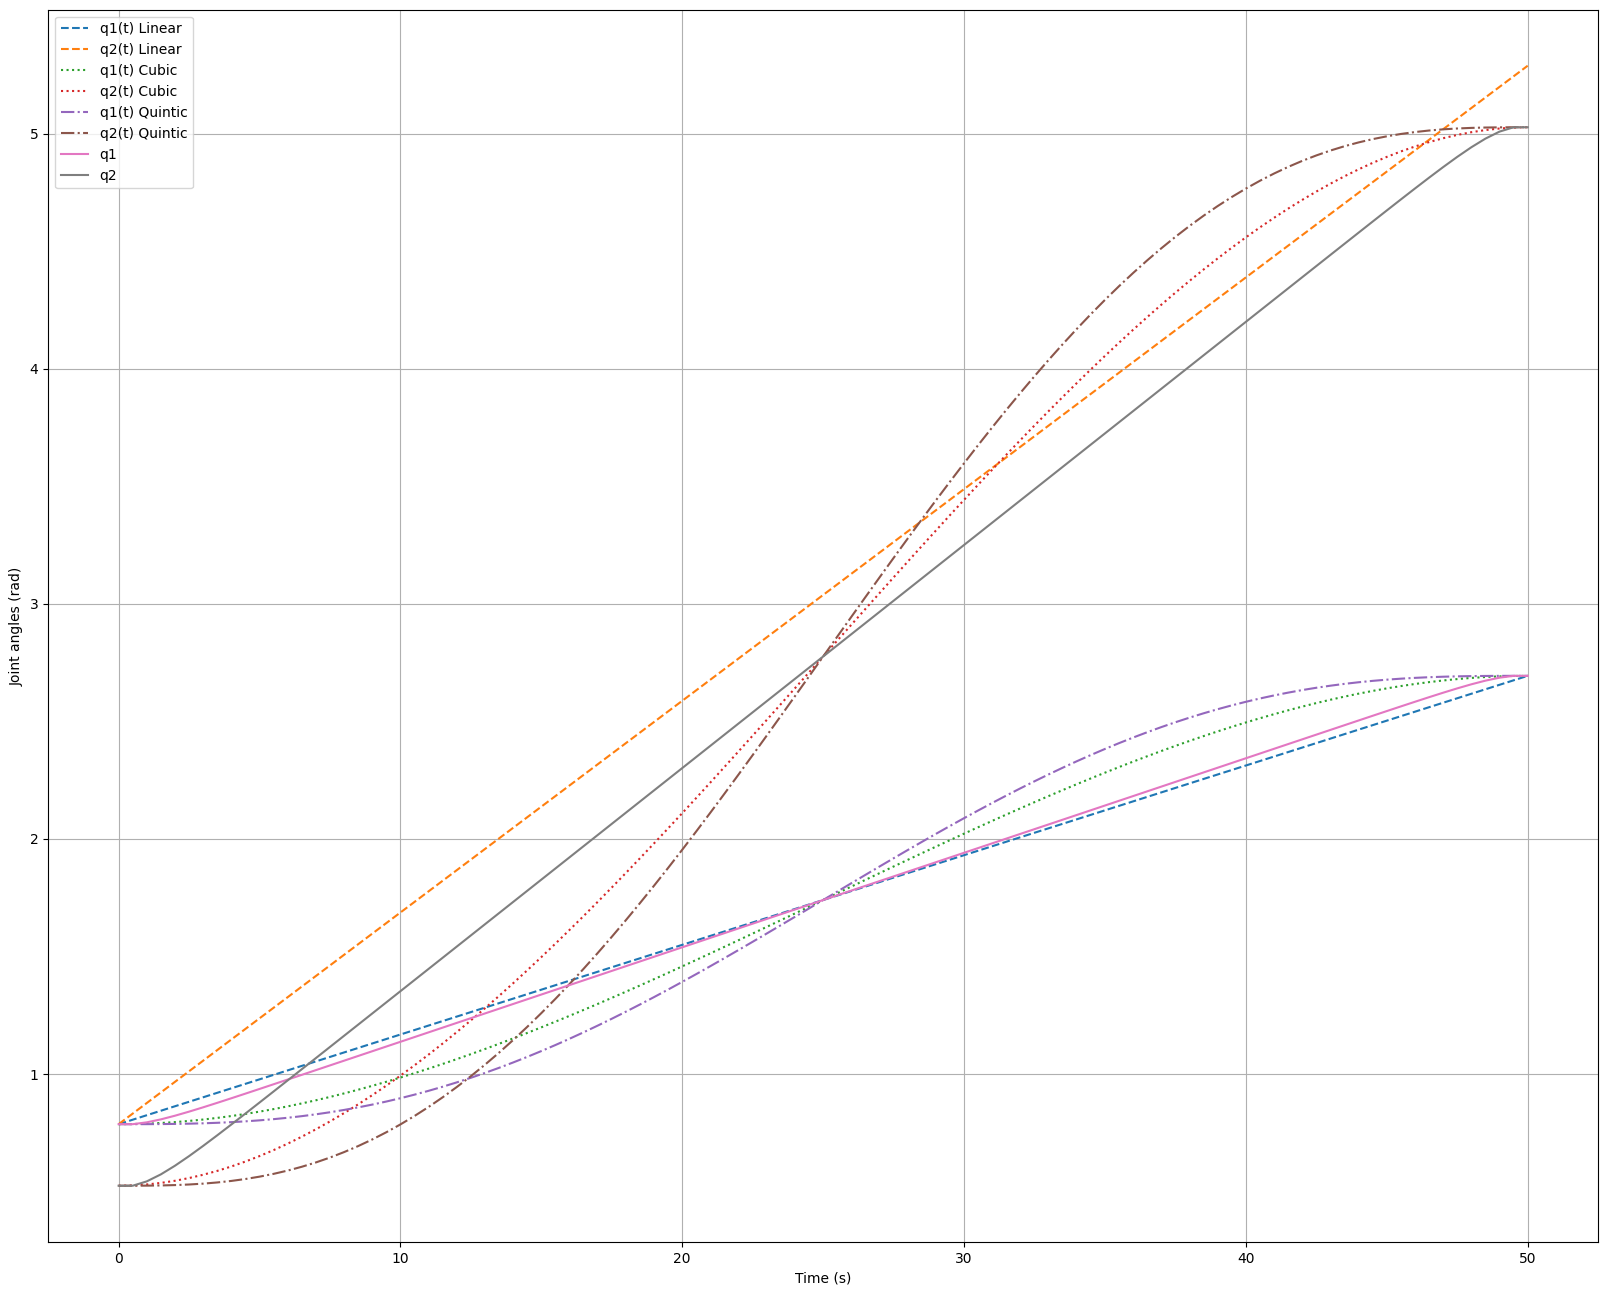

In [72]:
import matplotlib.pyplot as plt

t = np.linspace(0, T_opt, N+1)

plt.figure(figsize=(20, 16))
plt.plot(t,q1t_lin, linestyle='--', label='q1(t) Linear')
plt.plot(t,q2t_lin, linestyle='--', label='q2(t) Linear')
plt.plot(t,q1t_cub, linestyle=':', label='q1(t) Cubic')
plt.plot(t,q2t_cub, linestyle=':', label='q2(t) Cubic')
plt.plot(t,q1t, linestyle='-.', label='q1(t) Quintic')
plt.plot(t,q2t, linestyle='-.', label='q2(t) Quintic')
plt.plot(t, q_opt[:,0], label="q1")
plt.plot(t, q_opt[:,1], label="q2")
plt.xlabel("Time (s)")
plt.ylabel("Joint angles (rad)")
plt.legend()
plt.grid()
plt.show()


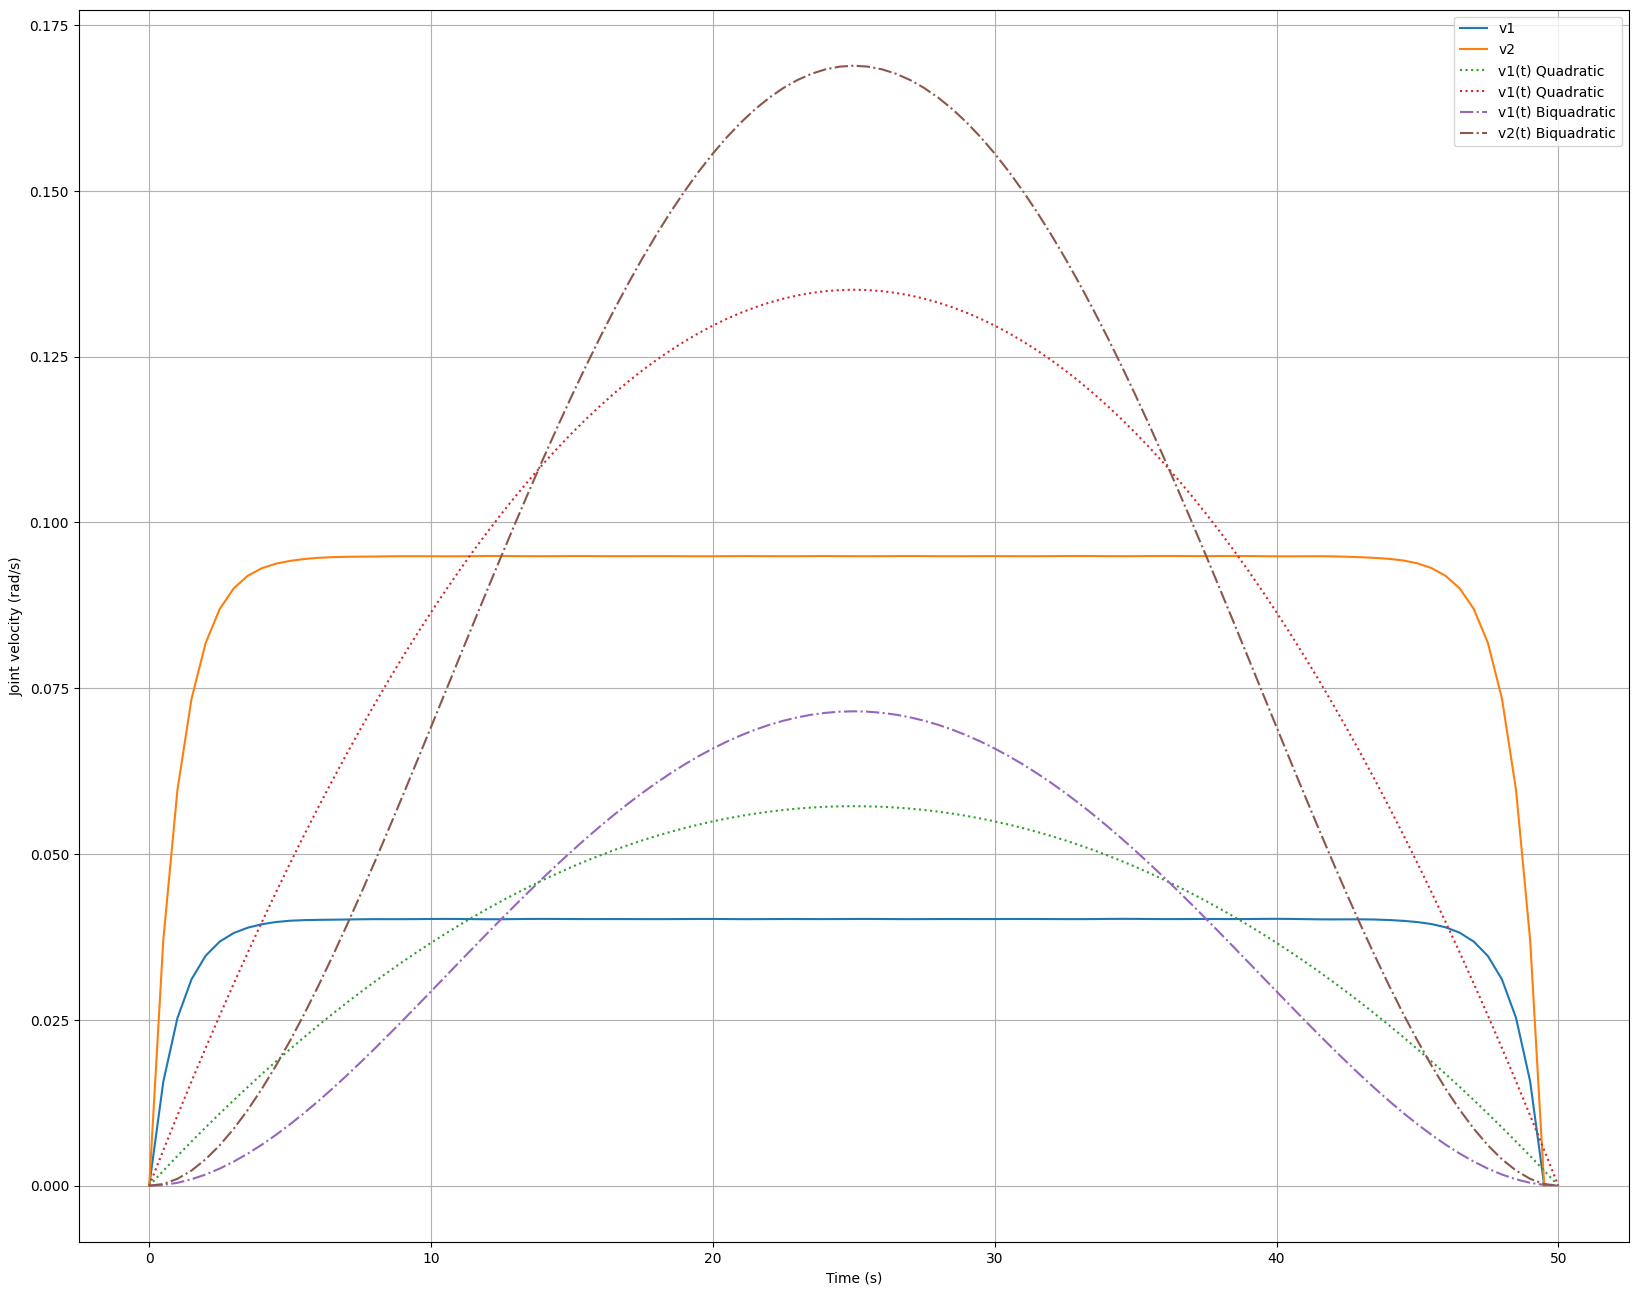

In [73]:
q1_traj = q_opt[:, 0]
q2_traj = q_opt[:, 1]
dt = T_opt / N
t_vel = t[:-1]   # time axis for velocities
q1_dot = (q1_traj[1:] - q1_traj[:-1]) / dt
q2_dot = (q2_traj[1:] - q2_traj[:-1]) / dt
plt.figure(figsize=(20, 16))
plt.plot(t_vel, q1_dot, label="v1")
plt.plot(t_vel, q2_dot, label="v2")
plt.plot(t,q1vt_cub, linestyle=':', label='v1(t) Quadratic')
plt.plot(t,q2vt_cub, linestyle=':', label='v1(t) Quadratic')

plt.plot(t,q1vt, linestyle='-.', label='v1(t) Biquadratic')
plt.plot(t,q2vt, linestyle='-.', label='v2(t) Biquadratic')
plt.xlabel("Time (s)")
plt.ylabel("Joint velocity (rad/s)")
plt.legend()
plt.grid()
plt.show()


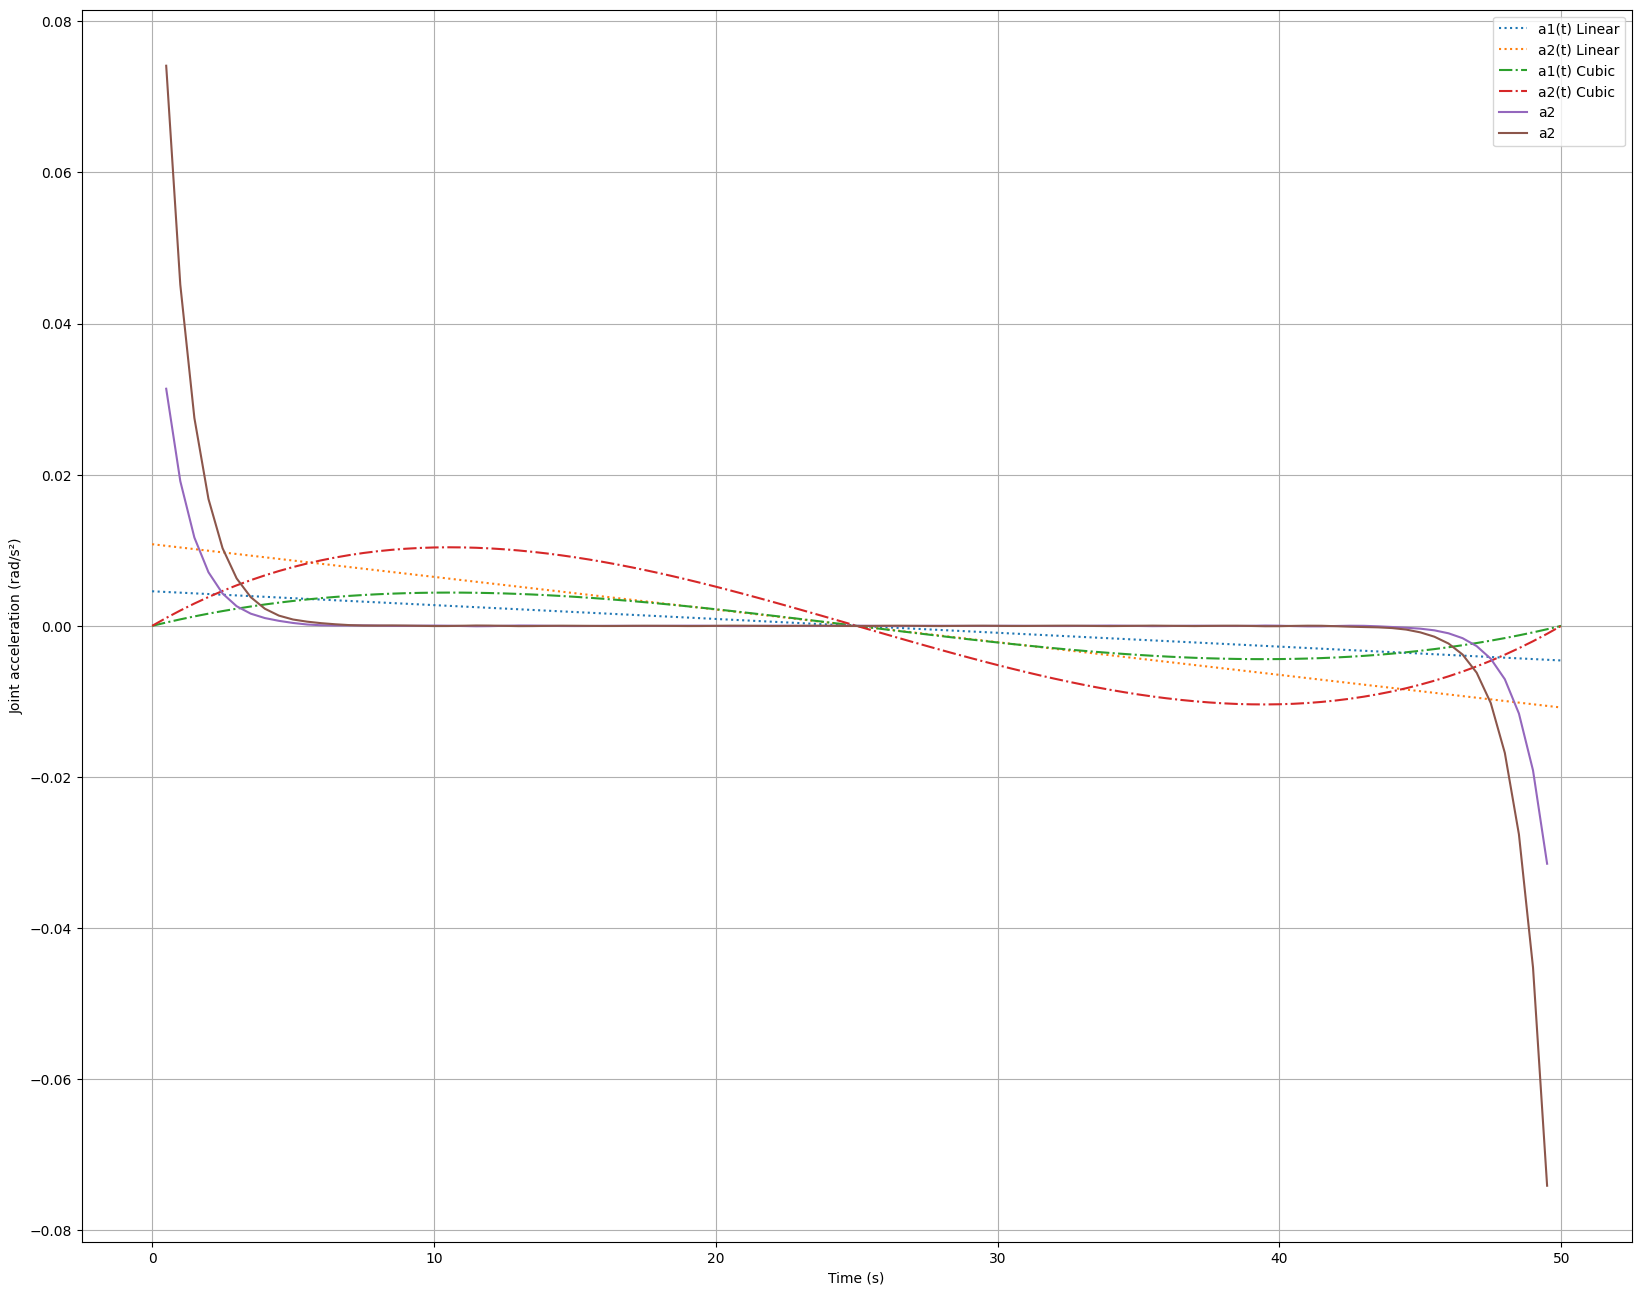

In [74]:
q1_ddot = (q1_traj[2:] - 2*q1_traj[1:-1] + q1_traj[:-2]) / dt**2
q2_ddot = (q2_traj[2:] - 2*q2_traj[1:-1] + q2_traj[:-2]) / dt**2
t_acc = t[1:-1]   # time axis for accelerations

plt.figure(figsize=(20,16))
plt.plot(t,q1at_cub, linestyle=':', label='a1(t) Linear')
plt.plot(t,q2at_cub, linestyle=':', label='a2(t) Linear')

plt.plot(t,q1at, linestyle='-.', label='a1(t) Cubic')
plt.plot(t,q2at, linestyle='-.', label='a2(t) Cubic')
plt.plot(t_acc, q1_ddot, label="a2")
plt.plot(t_acc, q2_ddot, label="a2")
plt.xlabel("Time (s)")
plt.ylabel("Joint acceleration (rad/s²)")
plt.legend()
plt.grid()
plt.show()


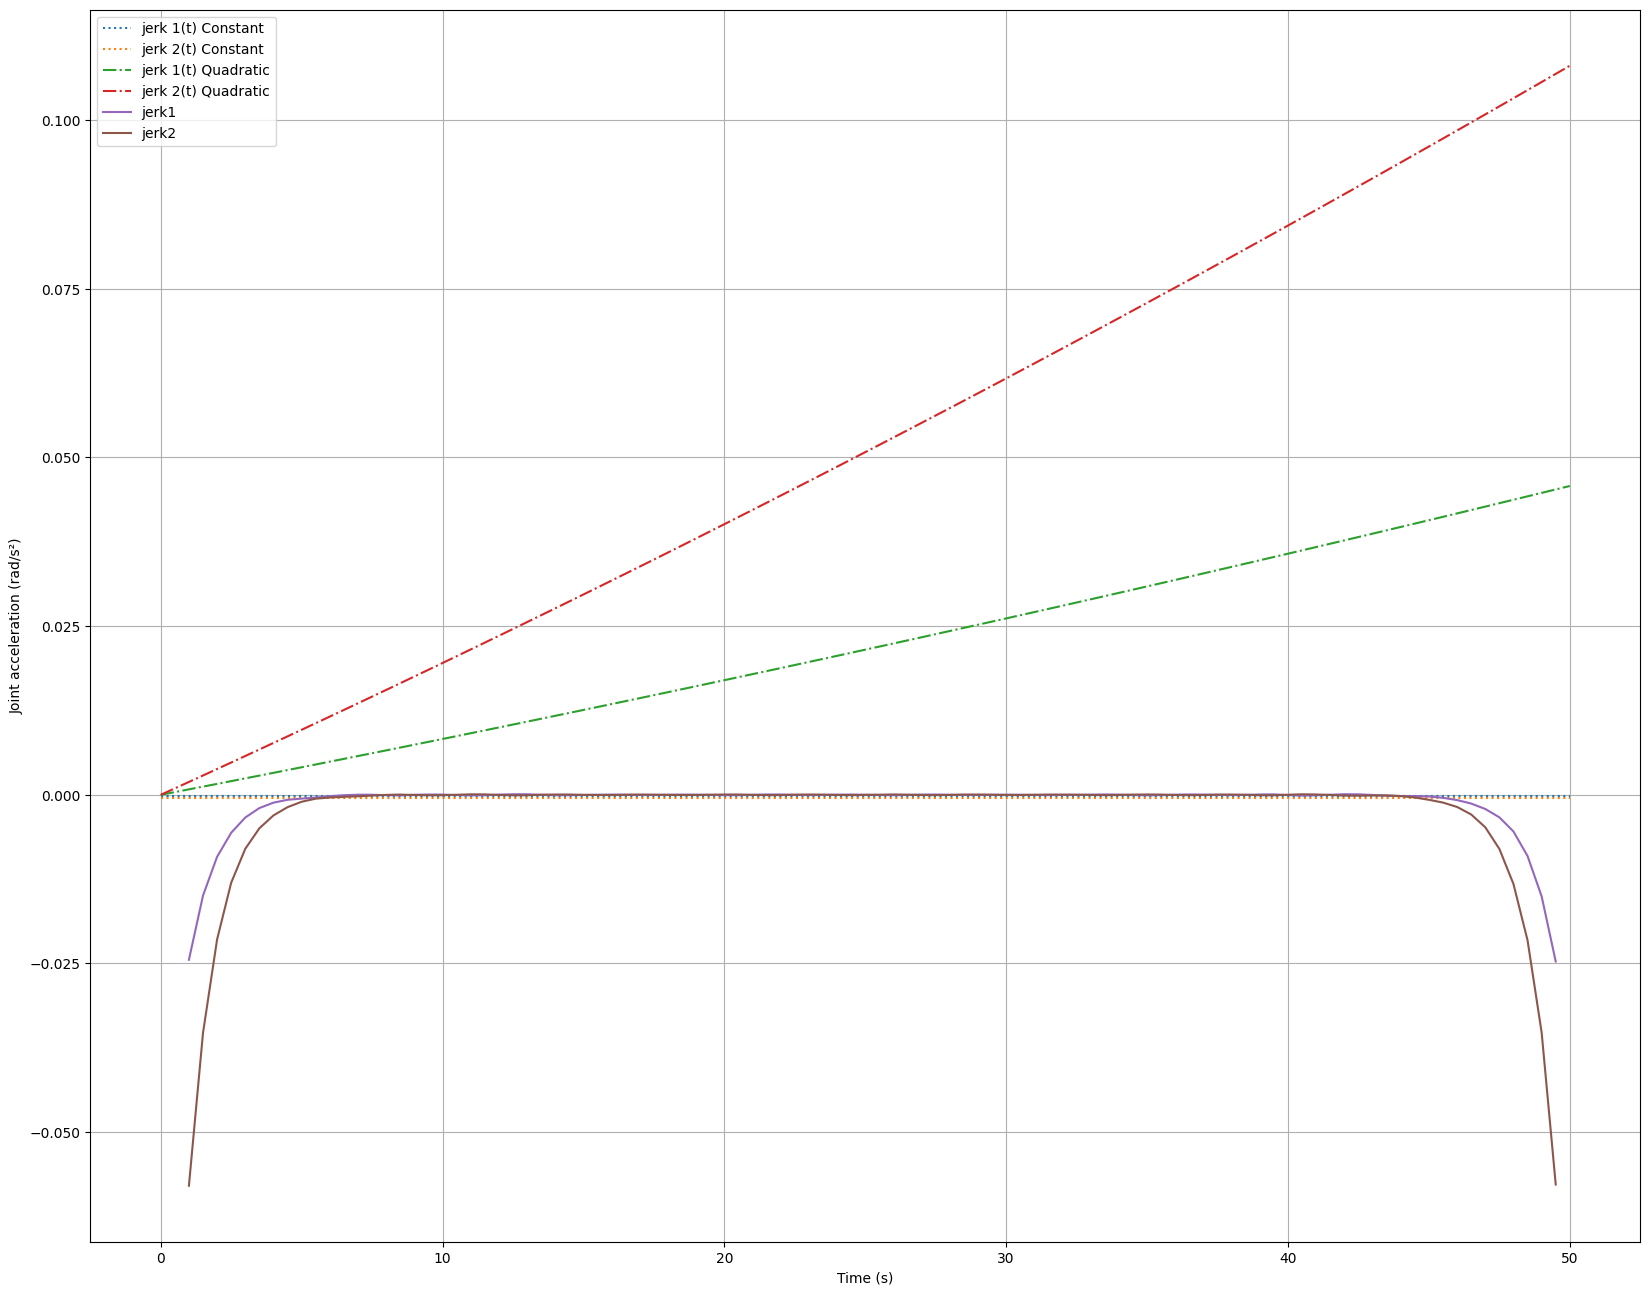

In [78]:
q1_jerk = (q1_traj[3:] - 3*q1_traj[2:-1] + 3*q1_traj[1:-2] - q1_traj[:-3]) / dt**3
q2_jerk = (q2_traj[3:] - 3*q2_traj[2:-1] + 3*q2_traj[1:-2] - q2_traj[:-3]) / dt**3

t_jerk = t[2:-1]   # time axis for jerk

plt.figure(figsize=(20,16))
plt.plot(t,q1jt_cub, linestyle=':', label='jerk 1(t) Constant')
plt.plot(t,q2jt_cub, linestyle=':', label='jerk 2(t) Constant')

plt.plot(t,q1jt, linestyle='-.', label='jerk 1(t) Quadratic')
plt.plot(t,q2jt, linestyle='-.', label='jerk 2(t) Quadratic')
plt.plot(t_jerk, q1_jerk, label="jerk1")
plt.plot(t_jerk, q2_jerk, label="jerk2")
plt.xlabel("Time (s)")
plt.ylabel("Joint acceleration (rad/s²)")
plt.legend()
plt.grid()
plt.show()

In [79]:
cost_before = cost(x0)
print("Cost before optimization:", cost_before)
cost_after = cost(result.x)
print("Cost after optimization:", cost_after)
improvement = 100 * (cost_before - cost_after) / cost_before
print(f"Cost reduction: {improvement:.2f}%")


Cost before optimization: 0.4782942335094357
Cost after optimization: 0.5041209693310944
Cost reduction: -5.40%
